In [1]:
# fetch requirements.txt 
!wget -q "https://raw.githubusercontent.com/DigitalProductschool/AI-Makerspace/master/PyCaret-Classification/requirements.txt"

In [ ]:
# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

!pip install -r requirements.txt

# Imports

In [3]:
# we only need pandas and pycaret
import pandas as pd
from joblib import dump
from pycaret.classification import *

# Data Preprocessing

Dataset Reference: https://www.kaggle.com/sriharipramod/bank-loan-classification

In [2]:
# fetch dataset 
!wget -q "https://raw.githubusercontent.com/DigitalProductschool/AI-Makerspace/master/PyCaret-Classification/UniversalBank.csv"

In [4]:
# reading dataset
dataset = pd.read_csv("UniversalBank.csv")

In [5]:
# removing spaces in col names
dataset.columns = [i.replace(" ", "") for i in dataset.columns]

In [6]:
# drop columns which are not significant
dataset.drop(["ID","ZIPCode"],axis=1,inplace=True)

In [7]:
# definign categorical features
cat_cols = ["Family","Education","SecuritiesAccount","CDAccount","Online","CreditCard"] 

In [8]:
# defining train and test datasets --> 90% train and 10% test
data = dataset.sample(frac=0.9, random_state=786)
data_unseen = dataset.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (4500, 12)
Unseen Data For Predictions: (500, 12)


# Model

### setup
This function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment.

In [9]:
# initializing the env
exp_mclf101 = setup(data = data, 
                    session_id=123, 
                    target = 'PersonalLoan', 
                    categorical_features=cat_cols,
                    normalize=True, 
                    normalize_method='minmax',
                    transformation=True,
                    use_gpu=False,
                    log_experiment=True,
                    experiment_name='loan1',
                    silent=True,
                    imputation_type='iterative') 

,Description,Value
0,session_id,123
1,Target,PersonalLoan
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(4500, 12)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


### compare_models
This function uses all models in the model library and scores them using Stratified Cross Validation.

In [10]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9867,0.9980,0.8929,0.9737,0.9305,0.9231,0.9248,0.1770
lightgbm,Light Gradient Boosting Machine,0.9867,0.9980,0.8864,0.9804,0.9294,0.9221,0.9245,0.0520
xgboost,Extreme Gradient Boosting,0.9860,0.9971,0.9086,0.9522,0.9285,0.9207,0.9219,6.8990
catboost,CatBoost Classifier,0.9860,0.9980,0.8865,0.9736,0.9262,0.9186,0.9209,1.3430
gbc,Gradient Boosting Classifier,0.9854,0.9972,0.9024,0.9514,0.9251,0.9171,0.9181,0.1380
et,Extra Trees Classifier,0.9844,0.9903,0.8517,0.9926,0.9161,0.9076,0.9112,0.1560
dt,Decision Tree Classifier,0.9790,0.9449,0.9021,0.8968,0.8974,0.8857,0.8870,0.0150
ada,Ada Boost Classifier,0.9698,0.9808,0.8020,0.8915,0.8406,0.8241,0.8277,0.0730
lr,Logistic Regression,0.9654,0.9721,0.7385,0.9055,0.8113,0.7925,0.7987,0.3610
svm,SVM - Linear Kernel,0.9584,0.0000,0.7038,0.8738,0.7718,0.7495,0.7591,0.0090


### create_models
This function creates a model and scores it using Stratified Cross Validation.

In [11]:
# Let's create the model
rf = create_model('rf', fold = 5, round=4) # model code, cv fold, and rounding upto _ places.

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9857,0.9993,0.8730,0.9821,0.9244,0.9165,0.9185
1,0.9810,0.9943,0.8571,0.9474,0.9000,0.8895,0.8909
2,0.9825,0.9966,0.8438,0.9818,0.9076,0.8980,0.9011
3,0.9889,0.9978,0.9219,0.9672,0.9440,0.9378,0.9382
4,0.9905,0.9976,0.9206,0.9831,0.9508,0.9455,0.9462
Mean,0.9857,0.9971,0.8833,0.9723,0.9254,0.9175,0.9190
Std,0.0036,0.0017,0.0324,0.0138,0.0198,0.0218,0.0211


### plot_models
This function takes a trained model object and returns a plot based on the test / hold-out set.

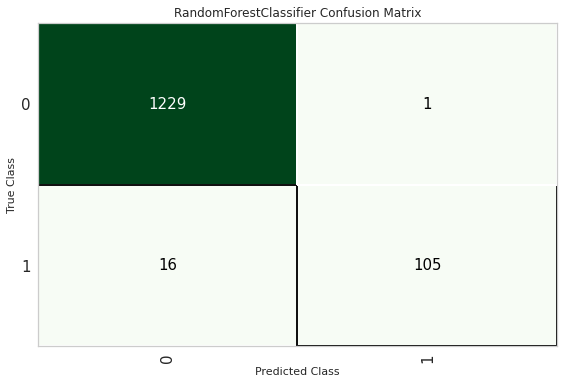

In [13]:
plot_model(rf, plot = 'confusion_matrix')

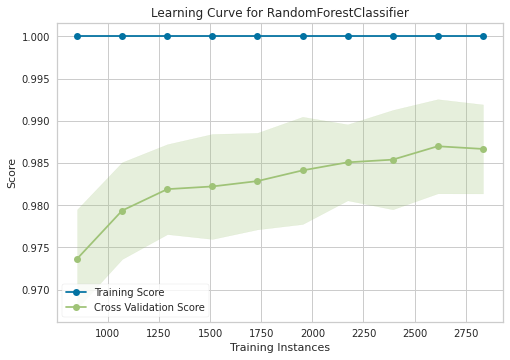

In [15]:
plot_model(rf,plot="learning")

### tune_model
This function tunes the hyperparameters of a model and the best model is selected based on the metric defined in optimize parameter.

In [16]:
tuned_rf = tune_model(rf, optimize = 'AUC') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9873,0.9992,1.0000,0.8857,0.9394,0.9323,0.9345
1,0.9841,0.9969,1.0000,0.8611,0.9254,0.9165,0.9198
2,0.9683,0.9916,0.8750,0.8235,0.8485,0.8308,0.8312
3,0.9429,0.9943,0.9688,0.6458,0.7750,0.7438,0.7638
4,0.9778,0.9862,0.9062,0.8788,0.8923,0.8799,0.8801
5,0.9619,0.9907,0.9688,0.7381,0.8378,0.8167,0.8264
6,0.9714,0.9969,1.0000,0.7805,0.8767,0.8608,0.8693
7,0.9873,0.9913,0.9375,0.9375,0.9375,0.9304,0.9304
8,0.9810,0.9980,1.0000,0.8421,0.9143,0.9037,0.9079


### predict_model
This function is used to predict new data using a trained estimator.

In [17]:
# let's make a prediction of the remaining 30% of 70% as val set
predict_model(tuned_rf);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9711,0.9926,0.9587,0.7733,0.8561,0.8402,0.8462


### finalize_model
This function fits the estimator onto the complete dataset passed during the setup() stage.

In [18]:
# Training the whole 90% as one dataset (train+val)
final_rf = finalize_model(tuned_rf)

In [19]:
# Making predictions on the remaining 10% test dataset
unseen_predictions = predict_model(final_rf, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9680,0.9926,0.9762,0.7321,0.8367,0.8194,0.8298


,Age,Experience,Income,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard,Label,Score
0,37,13,29,4,0.4,2,155,0,0,0,1,0,0,0.9039
1,50,24,22,1,0.3,3,0,0,0,0,0,1,0,0.9004
2,29,5,45,3,0.1,2,0,0,0,0,1,0,0,0.8887
3,59,32,40,4,2.5,2,0,0,0,0,1,0,0,0.8875
4,46,21,193,2,8.1,3,0,1,0,0,0,0,1,0.8941


### save_model
This function saves the transformation pipeline and trained model object into the current active directory as a pickle file for later use.

In [20]:
# saving the model for deployment
save_model(final_rf, "model")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['Family',
                                                             'Education',
                                                             'SecuritiesAccount',
                                                             'CDAccount',
                                                             'Online',
                                                             'CreditCard'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='PersonalLoan',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,...
                  RandomFor